__File: test_notebook.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 16, 2021__

Jupyter notebook for testing out code or functions.

__Revision history:<br/>__
* Jun 16, 2021 - Comparing integration via looping vs using NumPy sum function.
* Jun 17, 2021 - Testing $^4$He momentum distributions.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import time
# Scripts made by A.T.
from Figures import figures_functions as ff
from densities import load_density
from dmd import deuteron_momentum_distributions
from Misc.fourier_transform import hankel_transformation_k2r
import observables as ob
from Potentials.vsrg_macos import vnn
from pmd import pair_momentum_distributions
from snmd import single_nucleon_momentum_distributions
from SRG.srg_unitary_transformation import SRG_unitary_transformation

__Set-up__

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

In [4]:
kvnn = 6
channels = ('1S0', '3S1')
lamb = 1.35
# lamb = 2.0
kmax, kmid, ntot = 15.0, 3.0, 120

# Get momentum and weights (channel argument doesn't matter here)
q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

__Densities__

0.9998427298460154
1.9975927912830869
5.999999045057944
8.000000969165516
20.000001589143793
19.999995871341486
25.999998809232615
81.99999654029214


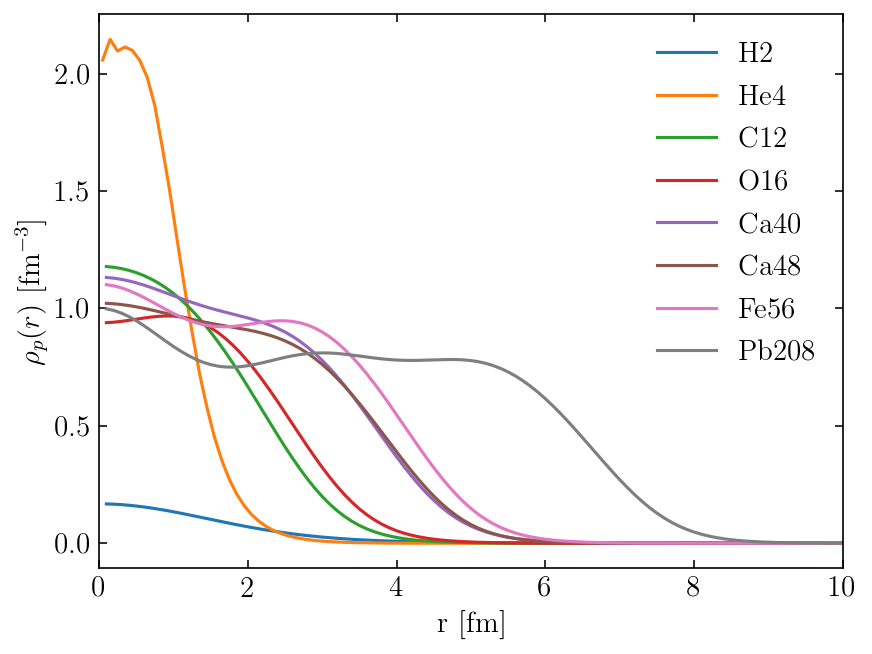

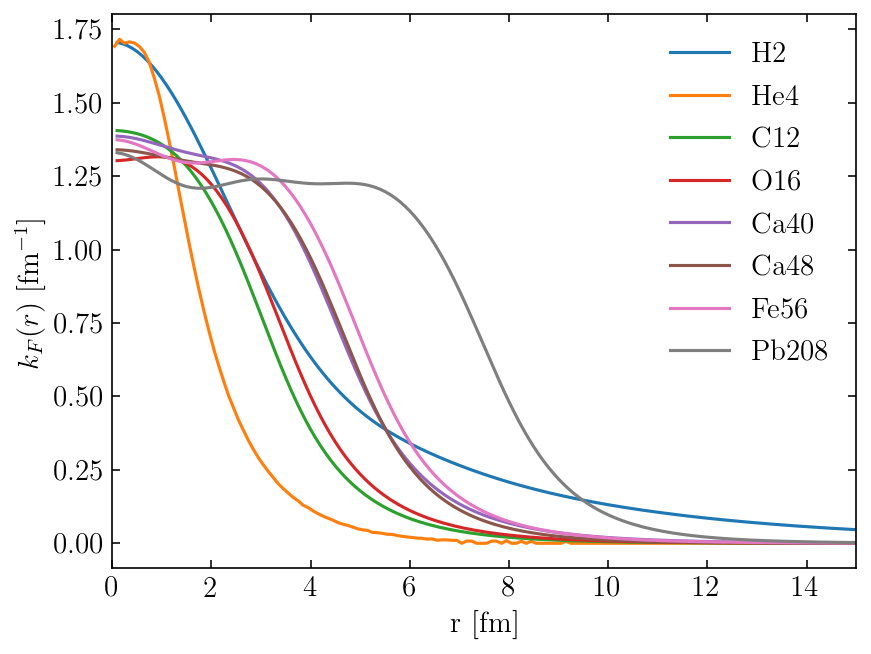

In [5]:
# Details of example nuclei (format is (nuclei, Z, N) )
nuclei_details = ( ('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
                   ('Ca48', 20, 28), ('Fe56', 26, 30), ('Pb208', 82, 126) )

# Get deuteron density
# Load evolved deuteron wave function in momentum-space
channel = '3S1'
H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator='Wegner', lamb=lamb)
U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
psi_k_unitless = ob.wave_function(H_initial, U=U_matrix)
        
# Divide out momenta/weights
factor_array = np.concatenate( (np.sqrt(q_weights) * q_array, np.sqrt(q_weights) * q_array) ) * np.sqrt(2/np.pi)
psi_k = psi_k_unitless / factor_array

dr = 0.1
r_d_array = np.linspace(dr, 20.0, 200)
hank_trans_3S1 = hankel_transformation_k2r('3S1', q_array, q_weights, r_d_array)
hank_trans_3D1 = hankel_transformation_k2r('3D1', q_array, q_weights, r_d_array)
    
psi_r_3S1 = hank_trans_3S1 @ psi_k[:ntot]
psi_r_3D1 = hank_trans_3D1 @ psi_k[ntot:]
    
rho_d = psi_r_3S1**2 + psi_r_3D1**2
    
# This is normalized to 1
normalization = np.sum(r_d_array**2 * rho_d) * dr
print(normalization)
    
kF_pn_array = ( 3*np.pi**2 * rho_d )**(1/3)
    
# Plot densities as a function of r
plt.clf()

# Deuteron first
plt.plot(r_d_array, rho_d, label='H2')

for i, nuclei_list in enumerate(nuclei_details):
        
    # Plot density for some nuclei here
    nucleus = nuclei_list[0]
    nucleon = 'proton'
    Z = nuclei_list[1]
    N = nuclei_list[2]
    if nucleus == 'He4':
        r_array, rho_array = load_density(nucleus, nucleon, Z, N, 'AV18')
    else:
        r_array, rho_array = load_density(nucleus, nucleon, Z, N, 'SLY4')

#     plt.plot(r_array, rho_array, label=nucleus)
    plt.plot(r_array, 4*np.pi*rho_array, label=nucleus)
    
    print( 4*np.pi*np.sum(0.1 * r_array**2 * rho_array) )
    
#     if nucleus == 'He4':
#         norm = 4*np.pi*np.sum(0.1 * r_array**2 * rho_array)
#         r = 4*np.pi*np.sum(0.1*r_array**4*rho_array)
#         print('He4 radius = %.5f ' % (np.sqrt(r/norm)))
        
plt.xlim( [0.0, 10.0] )
plt.legend(loc='upper right', frameon=False)
plt.xlabel('r [fm]')
plt.ylabel(r'$\rho_p(r)$' + ' [fm' + r'$^{-3}$' + ']')
plt.show()
    
# Plot proton k_F for some nuclei as function of r
plt.clf()

# Deuteron first
plt.plot(r_d_array, kF_pn_array, label='H2')

for j, nuclei_list in enumerate(nuclei_details):
        
    # Plot density for some nuclei here
    nucleus = nuclei_list[0]
    nucleon = 'proton'
    Z = nuclei_list[1]
    N = nuclei_list[2]
    if nucleus == 'He4':
        r_array, rho_array = load_density(nucleus, nucleon, Z, N, 'AV18')
    else:
        r_array, rho_array = load_density(nucleus, nucleon, Z, N)
    kF_array = ( 3*np.pi**2 * rho_array )**(1/3)

    plt.plot(r_array, kF_array, label=nucleus)

plt.xlim( [0.0, 15.0] )
plt.legend(loc='upper right', frameon=False)
plt.xlabel('r [fm]')
plt.ylabel(r'$k_F(r)$' + ' [fm' + r'$^{-1}$' + ']')
plt.show()

__Write single-nucleon distribution files__

In [6]:
# snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)

# nucleus, Z, N = 'He4', 2, 2

# t0 = time.time()
# snmd.write_files(nucleus, 'proton', Z, N, 'AV18')
# t1 = time.time()

# mins = (t1-t0)/60
# print('%.5f minutes elapsed.' % mins)

__Proton momentum distribution__

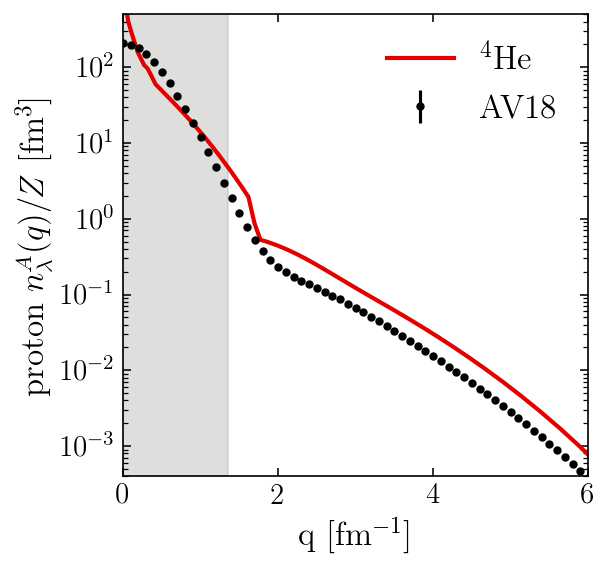

In [7]:
# Compare to AV18 QMC He4 momentum distribution
# (copied from snmd_tails_with_AV18 in src_physics_fig.ipynb)

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q)/Z$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 6)
ylim = (4e-4, 5e2)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Use interpolated function for proton distribution
snmd_interp = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=True)

nucleon = 'proton'
nucleus_name = 'He4'
Z = 2
N = 2
# nucleus_name = 'C12'
# Z = 6
# N = 6

# Ignore 1, \delta U, and \delta U^2 isolated contributions (take total only)
n_p_func, _, _, _ = snmd_interp.n_lambda_interp(nucleus_name, nucleon, Z, N)

# Evaluate at all q values and divide by Z
n_p_array = n_p_func(q_array) / Z

# Legend label
curve_label = ff.nuclei_label_conversion(nucleus_name) # Labels the nucleus
    
# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curve to figure
ax.plot(q_array, n_p_array, color='xkcd:red', label=curve_label, linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt('Figures/SRC_physics/Data/AV18_%s_snmd.txt' % nucleus_name)
q_array_av18 = av18_data[:, 0] # fm^-1
n_p_array_av18 = av18_data[:, 1] / Z
error_bars_array_av18 = av18_data[:, 2] / Z
            
# AV18 data with error bars
ax.errorbar(q_array_av18, n_p_array_av18, yerr=error_bars_array_av18, color='xkcd:black', label='AV18',
            linestyle='', marker='.')
    
# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 16
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

In [8]:
print(q_array[60], n_p_array[60])
print(q_array_av18[30], n_p_array_av18[30])
print(np.sum(q_weights*q_array**2*n_p_array)*4*np.pi/(2*np.pi)**3)
print(np.sum(0.1*q_array_av18**2*n_p_array_av18)*4*np.pi/(2*np.pi)**3)

3.0047392606354 0.12143000692451486
3.0 0.06675
1.0092024800247124
1.0000159378248867


In [9]:
0.12143000692451486/0.05387

2.2541304422594184

__Pair momentum distributions__

In [ ]:
# Compare to AV18 QMC He4 pair momentum distribution

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = r'$n_{\lambda}^A(q,0)/Z$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 5)
ylim = (1e-2, 4e6)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Initialize pair momentum distributions class
pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

nucleon = 'proton'
nucleus_name = 'He4'
Z = 2
N = 2
# nucleus_name = 'C12'
# Z = 6
# N = 6

# Get densities
r_array, rho_array = load_density(nucleus_name, nucleon, Z, N, 'AV18')

# Ignore 1, \delta U, and \delta U^2 isolated contributions (take total only)
n_pn_array = 2*pmd.n_lambda(q_array, r_array, rho_array, rho_array)[:, 0]
n_pp_array = pmd.n_lambda(q_array, r_array, rho_array)[:, 0]
    
# Set y-axis to log scale
ax.set_yscale('log')
    
# Add curve to figure
ax.plot(q_array, n_pp_array, color='xkcd:red', label=ff.nuclei_label_conversion(nucleus_name) + ' pp',
        linewidth=curve_width)
ax.plot(q_array, n_pn_array, color='xkcd:blue', label=ff.nuclei_label_conversion(nucleus_name) + ' np',
        linewidth=curve_width)
        
# Add AV18 data with error bars
av18_data = np.loadtxt('Figures/SRC_physics/Data/AV18_%s_pmd.txt' % nucleus_name)
q_array_av18 = av18_data[:, 0] # fm^-1
n_pn_array_av18 = av18_data[:, 1]
pn_error_bars_array_av18 = av18_data[:, 2]
n_pp_array_av18 = av18_data[:, 3]
pp_error_bars_array_av18 = av18_data[:, 4]
            
# AV18 data with error bars
ax.errorbar(q_array_av18, n_pp_array_av18, yerr=pp_error_bars_array_av18, color='xkcd:red', label='AV18 pp',
            linestyle='', marker='.')
ax.errorbar(q_array_av18, n_pn_array_av18, yerr=pn_error_bars_array_av18, color='xkcd:blue', label='AV18 np',
            linestyle='', marker='.')
    
# Shade gray from 0 to \lambda value on plot
ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.3)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 16
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

In [ ]:
print(q_array[60], n_pp_array[60])
print(q_array_av18[30], n_pp_array_av18[30])

In [ ]:
print(q_array[60], n_pn_array[60])
print(q_array_av18[30], n_pn_array_av18[30])

In [ ]:
1/(0.40076313792765617/0.95115)

In [ ]:
13.79/4.6629544836461925

__Deuteron momentum distribution__

In [ ]:
# Compare deuteron LDA to AV18 deuteron

channel = '3S1'
factor_array = q_array**2 * q_weights
    
# Load hamiltonian
H_matrix = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    
# Load exact wave function [unitless]
psi_exact_unitless = ob.wave_function(H_matrix)
psi_squared_exact = ( psi_exact_unitless[:ntot]**2 + psi_exact_unitless[ntot:]**2 ) / factor_array
        
# Calculate using LDA
dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot, interp=True)

# Ignore 1, \delta U, and \delta U^2 isolated contributions (take total only)
n_d_func, _, _, _ = dmd.n_lambda_interp()

# Evaluate at all q values
n_d_array = n_d_func(q_array)
    
# Normalization of wave function
norm = np.sum(factor_array * psi_squared_exact)
print('Normalization of exact: \dq q^2 n_d(q) = %.5f' % norm)
    
# Normalization of LDA deuteron momentum distribution
lda_factor = 4*np.pi * 1/(2*np.pi)**3
norm_lda = lda_factor * np.sum(factor_array * n_d_array)
print('Normalization of LDA: 4\pi/(2\pi)^3 \dq q^2 <n_d^N(q)> = %.5f' % norm_lda) 
    
# Plot pair momentum distributions
plt.semilogy(q_array, psi_squared_exact, label='AV18 wave function')
plt.semilogy(q_array, n_d_array * lda_factor, label='LDA')
plt.xlim( (0.0, 5.0) )
plt.ylim( (1e-5, 5e2) )
plt.xlabel(r'$q$' + ' [fm' + r'$^{-1}$' + ']')
plt.ylabel(r'$n_d(q)$' + ' [fm' + r'$^3$' + ']')
plt.legend(loc=0)